In [1]:
import sys
import jupyter
from IPython.display import display 
from IPython.display import HTML

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import RMSprop

set_random_seed(2)

/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-

# Read Dataset and Subsection into a Useful Dataframe

In [5]:
#reading cdc health and wellness dataset
#sourced from
data = pd.read_csv("LLCP2019.csv")

/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,10,12,13,14,16,18,19,21,22,23,24,25,26,28,29,30,32,33,34,36,37,38,39,40,42,45,46,47,48,50,51,52,53,54,55,57,63,64,65,66,68,69,173,175,176,224,227,233,234,235,236,242,264,265,267,268,269,270) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
data.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1,_FLSHOT7,_PNEUMO3,_AIDTST4
0,1,1,1182019,1,18,2019,1100,2019000001,2019000001,1,...,114,1,1,1,1,0,0,2,1,2
1,1,1,1132019,1,13,2019,1100,2019000002,2019000002,1,...,121,1,1,1,1,0,0,1,1,2
2,1,1,1182019,1,18,2019,1100,2019000003,2019000003,1,...,164,1,1,1,1,0,0,1,2,2
3,1,1,1182019,1,18,2019,1200,2019000004,2019000004,1,...,.,9,9,1,1,1,1,9,9,.
4,1,1,1042019,1,4,2019,1100,2019000005,2019000005,1,...,178,1,1,1,1,0,0,2,1,2


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392127 entries, 0 to 392126
Columns: 342 entries, _STATE to _AIDTST4
dtypes: float64(5), int64(62), object(275)
memory usage: 1023.2+ MB


# Data Preprocessing

In [8]:
# in this function we replace "blanks" with dummy values of -1000, 
#   we make sure everything is numeric, we drop rows where there is no info on our label variable, 
#   and we reassign our label variable to consecutive values

def preprocess(dataset, label_col): 
    dataset = dataset.replace({".": "-1000"})
    dataset = dataset.apply(pd.to_numeric)
    dataset.drop(dataset[dataset[label_col] == -1000].index, inplace = True)
    dataset[label_col] = dataset[label_col].replace({1: 0, 2: 1, 7: 2, 9: 3})
    dataset.drop(dataset[dataset[label_col] == 3].index, inplace = True)
    return dataset


In [9]:
# let's preprocess our original dataset
data_orig_clean = preprocess(data, "ADDEPEV3")

## Correlation Maps to Determine Important Features

### Let's Evaluate the ORIGINAL DATASET For Correlations

In [10]:
#Let's inspect the exact correlations...
corr = data_orig_clean.corr()
corr["ADDEPEV3"].sort_values(ascending=False)
top_correlations = corr[corr["ADDEPEV3"] >= 0.1]
bottom_correlations = corr[corr["ADDEPEV3"] <= -0.1]
top_correlations["ADDEPEV3"].sort_values(ascending = False)

ADDEPEV3    1.000000
MENTHLTH    0.321096
PHYSHLTH    0.179521
_SMOKER3    0.108554
ASTHMA3     0.101479
_INCOMG     0.100051
Name: ADDEPEV3, dtype: float64

In [11]:
bottom_correlations["ADDEPEV3"].sort_values(ascending = False)

CDDISCUS   -0.106642
CDSOCIAL   -0.106665
CDHOUSE    -0.106709
CDASSIST   -0.106812
SMOKDAY2   -0.110649
SEXVAR     -0.116216
_SEX       -0.116287
_PHYS14D   -0.122837
STOPSMK2   -0.132412
_RFHLTH    -0.137623
ASTHNOW    -0.139186
LMTJOIN3   -0.142181
ARTHDIS2   -0.142183
ARTHEXER   -0.142248
ARTHEDU    -0.142250
JOINPAI2   -0.142574
_MENT14D   -0.240257
POORHLTH   -0.272491
Name: ADDEPEV3, dtype: float64

In [12]:
#this is mostly to make a nice visualization table for the write-up 
correlations_table = pd.concat([top_correlations["ADDEPEV3"], bottom_correlations["ADDEPEV3"]])
correlations_table = correlations_table.to_frame()
display(correlations_table.sort_values(by = "ADDEPEV3", ascending = False))

,ADDEPEV3
ADDEPEV3,1.000000
MENTHLTH,0.321096
PHYSHLTH,0.179521
_SMOKER3,0.108554
ASTHMA3,0.101479
_INCOMG,0.100051
CDDISCUS,-0.106642
CDSOCIAL,-0.106665
CDHOUSE,-0.106709
CDASSIST,-0.106812


### We will now assign our dataset that we will use in the future and evaluate the top correlations there. 

In [13]:
data_use_clean = data_orig_clean[["_STATE", "CADULT1", "PVTRESD3", "CCLGHOUS",
                   "HHADULT", "SEXVAR", "GENHLTH", "PHYSHLTH", "MENTHLTH", "ASTHMA3",
                   "POORHLTH", "ADDEPEV3", "MARITAL", "EDUCA", "RENTHOM1", "_INCOMG", 
                   "VETERAN3", "EMPLOY1", "CHILDREN", "INCOME2", "WEIGHT2",
                   "HEIGHT3", "PREGNANT", "SMOKE100", "SMOKDAY2", "STOPSMK2"
                   , "LASTSMK2", "ALCDAY5", "AVEDRNK3", "DRNK3GE5"
                   , "MAXDRNKS", "EXERANY2", "EXRACT11","EXRACT21", "EXERHMM2", 
                   "STRENGTH", "FRUIT2", "FVGREEN1", "FRENCHF1", "VEGETAB2",
                   "ACEDEPRS", "ACEDRINK", "ACEDRUGS", "ACEPRISN", 
                   "ACEDIVRC", "ACEPUNCH", "ACEHURT1", "ACESWEAR", 
                   "ACETOUCH", "ACETTHEM", "ACEHVSEX", "MARIJAN1", 
                   "USEMRJN2", "RSNMRJN1", "FOODSTMP", "BIRTHSEX", 
                   "SOMALE", "SOFEMALE", "TRNSGNDR", "DISPCODE", "_MENT14D", "JOINPAI2", "ARTHEDU", "_RFHLTH"]]

In [14]:
data_use_clean.shape

(391672, 64)

In [15]:
data_use_clean = data_use_clean.rename(columns = {"_STATE": "State", "CADULT1": "Adult", "PVTRESD3": "Private_Residence", "CCLGHOUS": "College_Housing",
                   "HHADULT": "Num_Adults_in_House", "SEXVAR": "Sex", "ASTHMA3": "Hist_Asthma", "ADDEPEV3": "History_Depressive_Disorder", "RENTHOM1": "Rent_home",
                   "VETERAN3": "Veteran", "EMPLOY1": "Employment_Status", "SMOKE100": "Have_Smoked_100_Cigs", "SMOKDAY2": "Freq_Days_Smoking", "STOPSMK2": "Stopped_Smoke_last_1_Months", 
                   "LASTSMK2": "Interval_Since_Last_Smoke", "ALCDAY5": "Days_in_Last_30_Had_Alcohol", "AVEDRNK3": "Avg_Drinks_Per_Day", "DRNK3GE5": "Num_Times_Bingge_Drink", "EXERANY2": "Exercise_Past_30_Days", 
                   "EXRACT11": "Type_Physical_Activity", "EXRACT21": "Other_Type_Exercise", "STRENGTH": "Num_Strength_Exercises", "FRUIT2": "Times_Ate_Fruit", "FVGREEN1": "Times_Ate_Dark_Green_Veggies", 
                   "FRENCHF1": "Fries", "VEGETAB2": "Other Vegetables", "ACEDEPRS": "Live with person Depressed", "ACEDRINK": "Live with Person Who Drinks", "ACEDRUGS": "Live With Person Who Does Drugs", 
                   "ACEPRISN": "Live_With_Person_Been_Imprisoned", "ACEDIVRC": "Parents_divorced?", "ACEPUNCH": "Freq_of_Parental_Violence", "ACEHURT1": "Freq_of_violence_to_you", "ACESWEAR": "Freq_Parents_Swearing", 
                   "ACETOUCH": "Freq_Sexual_Touch", "ACETTHEM": "Freq_Sexual_Touch_to_Them", "ACEHVSEX": "Freq_Forced_Sex", "MARIJAN1": "Freq_Marijuana_last_30_days", 
                   "USEMRJN2": "Freq_Primary_Marijuana", "RSNMRJN1": "Reason_for_Marijuana", "_MENT14D": "Days with Depression"})

## Feature Engineering

In [16]:
#initialize columns 
data_use_clean["Stressful_life_event"] = 0
data_use_clean["Persisting_Health_Issue"] = 0

In [17]:
#let's see if we can add a binary variable determining if the person has had a previous stressful event in their life 
for ind, i in data_use_clean.iterrows(): 
    if (i["Freq_Sexual_Touch"] >= 2) or (i["Freq_Sexual_Touch_to_Them"] >= 2) or (i["Freq_Forced_Sex"] >= 2) or (i["Freq_of_violence_to_you"] >= 3) or (i["Freq_of_Parental_Violence"] >= 3) or (i["Parents_divorced?"] == 1): #poor health
        i["Stressful_life_event"] = 1    
    else: 
        i["Stressful_life_event"] = 0


In [18]:
#let's also add a feature aggregating any persisting medical issue. 
# index, row in df.iterrows():
for ind, i in data_use_clean.iterrows(): 
    if (i["_RFHLTH"] == 2) or (i["ARTHEDU"] == 2) or (i["JOINPAI2"] >= 5) or (i["POORHLTH"] >= 15) or (i["Hist_Asthma"] == 1): #poor health
        i["Persisting_Health_Issue"] = 1
    else: 
        i["Persisting_Health_Issue"] = 0

In [19]:
data_use_clean.head()

,State,Adult,Private_Residence,College_Housing,Num_Adults_in_House,Sex,GENHLTH,PHYSHLTH,MENTHLTH,Hist_Asthma,...,SOMALE,SOFEMALE,TRNSGNDR,DISPCODE,Days with Depression,JOINPAI2,ARTHEDU,_RFHLTH,Stressful_life_event,Persisting_Health_Issue
0,1,-1000,-1000,-1000,-1000,2,3,15,88,2,...,-1000,-1000,-1000,1100,1,7,2,1,1,1
1,1,-1000,-1000,-1000,-1000,2,4,10,88,2,...,-1000,-1000,-1000,1100,1,8,2,2,0,1
2,1,-1000,-1000,-1000,-1000,2,3,88,30,2,...,-1000,-1000,-1000,1100,3,4,2,1,1,1
3,1,-1000,-1000,-1000,-1000,2,4,30,88,2,...,-1000,-1000,-1000,1200,1,5,2,2,0,1
4,1,-1000,-1000,-1000,-1000,2,2,88,88,2,...,-1000,-1000,-1000,1100,1,-1000,-1000,1,0,0


### Now Let's Evaluate DATA_USE_CLEAN

In [20]:
# corr = data_use_clean.corr()
# fig, ax = plt.subplots(figsize=(70, 60))
# mask = np.triu(np.ones_like(corr, dtype=np.bool))
# ax = sea.heatmap(corr,  vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = mask)
# # ax.layout(yaxis = list(range = c(100, 50)))

In [21]:
#Let's inspect the exact correlations...
corr = data_use_clean.corr()
# corr['History_Depressive_Disorder'].sort_values(ascending=False)
top_correlations = corr[corr['History_Depressive_Disorder'] >= 0.05]
bottom_correlations = corr[corr['History_Depressive_Disorder'] <= -0.05]
top_correlations['History_Depressive_Disorder'].sort_values(ascending = False)

History_Depressive_Disorder    1.000000
MENTHLTH                       0.321096
PHYSHLTH                       0.179521
Hist_Asthma                    0.101479
_INCOMG                        0.100051
SOMALE                         0.071603
Type_Physical_Activity         0.051975
Name: History_Depressive_Disorder, dtype: float64

In [22]:
bottom_correlations['History_Depressive_Disorder'].sort_values(ascending = False)

Reason_for_Marijuana          -0.050388
Freq_Primary_Marijuana        -0.050483
SOFEMALE                      -0.074694
Stressful_life_event          -0.076846
PREGNANT                      -0.096097
Freq_Days_Smoking             -0.110649
Sex                           -0.116216
Stopped_Smoke_last_1_Months   -0.132412
_RFHLTH                       -0.137623
ARTHEDU                       -0.142250
JOINPAI2                      -0.142574
Persisting_Health_Issue       -0.185476
Days with Depression          -0.240257
POORHLTH                      -0.272491
Name: History_Depressive_Disorder, dtype: float64

In [23]:
#this is mostly to make a nice visualization table for the write-up 
correlations_table = pd.concat([top_correlations['History_Depressive_Disorder'], bottom_correlations['History_Depressive_Disorder']])
correlations_table = correlations_table.to_frame()
display(correlations_table.sort_values(by = 'History_Depressive_Disorder', ascending = False))

,History_Depressive_Disorder
History_Depressive_Disorder,1.000000
MENTHLTH,0.321096
PHYSHLTH,0.179521
Hist_Asthma,0.101479
_INCOMG,0.100051
SOMALE,0.071603
Type_Physical_Activity,0.051975
Reason_for_Marijuana,-0.050388
Freq_Primary_Marijuana,-0.050483
SOFEMALE,-0.074694


In [24]:
# corr['History_Depressive_Disorder'].sort_values(ascending=False)

## Now we will perform some EDA 

In [25]:
# sea.countplot(x='History_Depressive_Disorder', hue = 'Sex', data=data_clean).set_title("History of Depressive Disorder by Sex")

In [26]:
# plt.figure(figsize=(100, 50))
# plt.xticks(size=50)
# plt.yticks(size = 50)
# ax = sea.countplot(x='PHYSHLTH', hue = 'Sex', data=data_clean)
# ax.set_title("Physical Health by Sex", size = 100)
# # ax.set(xlabel='common xlabel', ylabel='common ylabel')
# ax.set_xlabel("Physical Health Value",fontsize=75)
# ax.set_ylabel("Frequency",fontsize=75)
# plt.setp(ax.get_legend().get_texts(), fontsize='50') # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize='70') # for legend title

In [27]:
# plt.figure(figsize=(100, 50))
# plt.xticks(size=50)
# plt.yticks(size = 50)
# ax1 = sea.countplot(x='MENTHLTH', hue = 'Sex', data=data_clean)
# ax1.set_title("Mental Health by Sex", size = 100)
# ax1.set_xlabel("Mental Health Value",fontsize=75)
# ax1.set_ylabel("Frequency",fontsize=75)
# plt.setp(ax1.get_legend().get_texts(), fontsize='50') # for legend text
# plt.setp(ax1.get_legend().get_title(), fontsize='70') # for legend title

In [28]:
# plt.figure(figsize=(100, 100))
# plt.xticks(size=100)
# plt.yticks(size = 100)
# ax2 = sea.countplot(x= 'History_Depressive_Disorder', hue = 'Freq_Forced_Sex', data=data_clean)
# ax2.set_title("Depressive Disorder by Experience with Sexual Abuse", size = 100)
# ax2.set_xlabel("Depressive Disorder Value",fontsize=75)
# ax2.set_ylabel("Frequency",fontsize=75)
# plt.setp(ax2.get_legend().get_texts(), fontsize='100') # for legend text
# plt.setp(ax2.get_legend().get_title(), fontsize='100') # for legend title

In [29]:
# # sea.catplot( data=data_clean, x = "History_Depressive_Disorder", kind = "bar", y = "Freq_Forced_Sex")
# sea.countplot(data = data_clean, x = "Rent_home")

In [30]:
# plt.figure(figsize=(200, 80))
# plt.xticks(size=100)
# plt.yticks(size = 100)
# ax3 = sea.countplot(x= 'Num_Times_Bingge_Drink', hue ='History_Depressive_Disorder', data=data_clean)
# plt.setp(ax3.get_legend().get_texts(), fontsize='100') # for legend text
# plt.setp(ax3.get_legend().get_title(), fontsize='100') # for legend title

## Narrow Down Features Used In Classification 
We will do this by including all the features with correlations to history of depressive disorder above 0.1 and below -0.1 strength 

In [31]:
#ever feature we think might be important 
data_use_all = data_use_clean[["Persisting_Health_Issue", "Stressful_life_event", "MENTHLTH", "PHYSHLTH", "Freq_Days_Smoking", "Sex", "Stopped_Smoke_last_1_Months", "POORHLTH", "_INCOMG", "Hist_Asthma", "Days with Depression", "History_Depressive_Disorder"]]

#only engineered features 
data_use_1 = data_use_clean[["Persisting_Health_Issue", "Stressful_life_event", "History_Depressive_Disorder"]]

#top and bottom 3 correlations
data_use_2 = data_use_clean[["Persisting_Health_Issue", "MENTHLTH", "PHYSHLTH", "POORHLTH", "Hist_Asthma", "Days with Depression", "History_Depressive_Disorder"]]

# data_use_3 = data_use_clean[["Persisting_Health_Issue", "Stressful_life_event", "MENTHLTH", "PHYSHLTH", "Freq_Days_Smoking", "Sex", "Stopped_Smoke_last_1_Months", "POORHLTH", "_INCOMG", "Hist_Asthma", "Days with Depression", "History_Depressive_Disorder"]]

# data_use_4 = data_use_clean[["Persisting_Health_Issue", "Stressful_life_event", "MENTHLTH", "PHYSHLTH", "Freq_Days_Smoking", "Sex", "Stopped_Smoke_last_1_Months", "POORHLTH", "_INCOMG", "Hist_Asthma", "Days with Depression", "History_Depressive_Disorder"]]



In [32]:
# features_use_vis = {}
# features_use_vis['dataset_1'] = ["Persisting_Health_Issue", "Stressful_life_event", "MENTHLTH", "PHYSHLTH", "Freq_Days_Smoking", "Sex", "Stopped_Smoke_last_1_Months", 
#                                  "POORHLTH", "_INCOMG", "Hist_Asthma", "Days with Depression", "History_Depressive_Disorder"]
# features_use_vis['dataset_2'] = ["Persisting_Health_Issue", "Stressful_life_event", "History_Depressive_Disorder"]
# features_use_vis['dataset_3'] = ["Persisting_Health_Issue", "MENTHLTH", "PHYSHLTH", "POORHLTH", "Hist_Asthma", "Days with Depression", "History_Depressive_Disorder"]

# df_features = pd.DataFrame({'Features': [["Persisting_Health_Issue", "Stressful_life_event", "MENTHLTH", "PHYSHLTH", "Freq_Days_Smoking", "Sex", "Stopped_Smoke_last_1_Months", 
#                                  "POORHLTH", "_INCOMG", "Hist_Asthma", "Days with Depression", "History_Depressive_Disorder"], 
#                                          ["Persisting_Health_Issue", "Stressful_life_event", "History_Depressive_Disorder"], 
#                                          ["Persisting_Health_Issue", "MENTHLTH", "PHYSHLTH", "POORHLTH", "Hist_Asthma", "Days with Depression", "History_Depressive_Disorder"]]})
# df_features.rename(index = {0: 'dataset_1', 1: 'dataset_2', 2: 'dataset_3'})
# print(df_features)


# Separation of test and validation sets 

In [33]:
def data_sep(data): 
    data_train = data[:]
    #separate features from labels 
    X = np.array(data_train.drop(['History_Depressive_Disorder'], 1))
    y = np.array(data_train['History_Depressive_Disorder'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
    y_train_keras = tf.keras.utils.to_categorical(y_train, 3)
    y_test_keras = tf.keras.utils.to_categorical(y_test, 3)
    return X_train, X_test, y_train_keras, y_test_keras

# MLP Models with different feature combinations

In [34]:
def model_create(num_features):
    network = tf.keras.Sequential()
    network.add(layers.Dense(36, activation='sigmoid', input_shape=(num_features,))) 
    network.add(layers.Dense(36, activation='sigmoid')) 
    network.add(layers.Dense(36, activation='sigmoid')) 
    network.add(layers.Dense(3, activation='softmax'))
    return network

In [35]:
def model_compile(model, epoch_num, X_train, y_train_keras, X_test, y_test_keras):
    # we choose categorical crossentropy and accuracy because we did the one-hot categorical transformation above
    model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

    start=datetime.now()
    mod = model.fit(X_train, y_train_keras, epochs = epoch_num, validation_data = (X_test, y_test_keras))
    end=datetime.now()
    print("Run time: ", end-start)
    return mod

In [36]:
def plot_loss_metrics(history_dict, num_epochs, modelnum): 
    plot_title = 'Training and validation loss: Model ' + modelnum
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss']
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss') 
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title(plot_title) 
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    return plt

In [37]:
def plot_acc_metrics(history_dict, num_epochs, modelnum): 
    plot_title = 'Training and validation accuracy: Model ' + modelnum
    plt.clf() 
    epochs = range(1, num_epochs + 1)
    acc_values = history_dict['categorical_accuracy'] 
    val_acc_values = history_dict['val_categorical_accuracy']
    plt.plot(epochs, acc_values, 'bo', label='Training acc') 
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
    plt.title(plot_title) 
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy') 
    plt.legend()
    return plt

### Model 1

In [38]:
X_train, X_test, y_train_keras, y_test_keras = data_sep(data_use_all)
model1 = model_create(11)
model1.summary()
# mod1 = model_compile(model1, 20, X_train, y_train_keras, X_test, y_test_keras)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36)                432       
_________________________________________________________________
dense_1 (Dense)              (None, 36)                1332      
_________________________________________________________________
dense_2 (Dense)              (None, 36)                1332      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 111       
Total params: 3,207
Trainable params: 3,207
Non-trainable params: 0
_________________________________________________________________


In [1]:
history_dict1 = mod1.history
history_dict1.keys()

NameError: name 'mod1' is not defined

In [38]:
metrics_dict = {}
metrics_dict['model1'] = list([history_dict1['loss'][-1]*100, 
                               history_dict1['categorical_accuracy'][-1]*100, 
                               history_dict1['val_loss'][-1]*100, 
                               history_dict1['val_categorical_accuracy'][-1]*100])

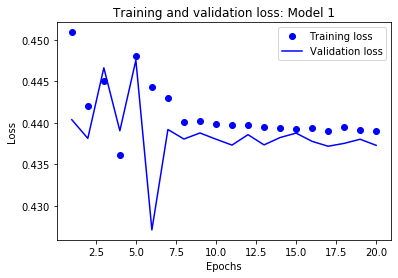

In [113]:
loss1 = plot_loss_metrics(history_dict1, 20, '1')
loss1.savefig('model1_loss.png')

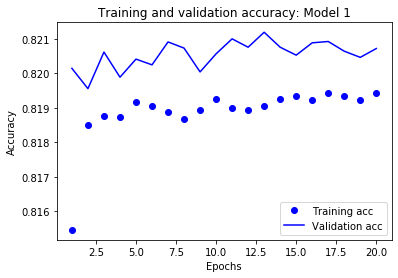

In [116]:
acc1 = plot_acc_metrics(history_dict1, 20, '1')
acc1.savefig('model1_acc.png')

In [41]:
# print(network.summary())

### Model 2

In [42]:
X_train2, X_test2, y_train_keras2, y_test_keras2 = data_sep(data_use_1)
model2 = model_create(2)
mod2 = model_compile(model2, 20, X_train2, y_train_keras2, X_test2, y_test_keras2)

Train on 313337 samples, validate on 78335 samples
Epoch 1/20
313337/313337 [==============================] - 11s 34us/sample - loss: 0.4958 - categorical_accuracy: 0.8050 - val_loss: 0.4881 - val_categorical_accuracy: 0.8069
Epoch 2/20
313337/313337 [==============================] - 11s 34us/sample - loss: 0.4902 - categorical_accuracy: 0.8061 - val_loss: 0.4888 - val_categorical_accuracy: 0.8069
Epoch 3/20
313337/313337 [==============================] - 11s 34us/sample - loss: 0.4900 - categorical_accuracy: 0.8061 - val_loss: 0.4881 - val_categorical_accuracy: 0.8069
Epoch 4/20
313337/313337 [==============================] - 11s 36us/sample - loss: 0.4899 - categorical_accuracy: 0.8061 - val_loss: 0.4892 - val_categorical_accuracy: 0.8069
Epoch 5/20
313337/313337 [==============================] - 10s 33us/sample - loss: 0.4897 - categorical_accuracy: 0.8061 - val_loss: 0.4889 - val_categorical_accuracy: 0.8069
Epoch 6/20
313337/313337 [==============================] - 11s 35us/

In [43]:
history_dict2 = mod2.history
# history_dict1.keys()

In [93]:
metrics_dict['model2'] = list([history_dict2['loss'][-1]*100, 
                               history_dict2['categorical_accuracy'][-1]*100, 
                               history_dict2['val_loss'][-1]*100, 
                               history_dict2['val_categorical_accuracy'][-1]*100])

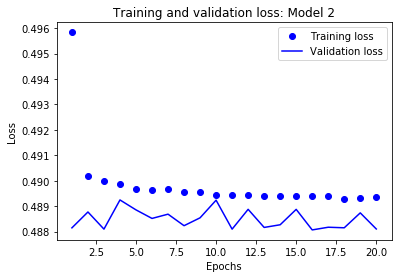

In [117]:
loss2 = plot_loss_metrics(history_dict2, 20, '2')
loss2.savefig('model2_loss.png')

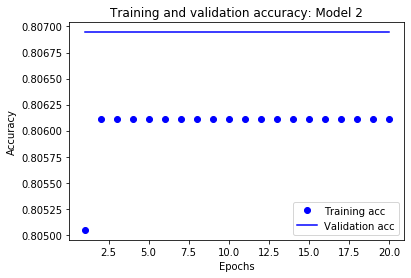

In [118]:
acc2 = plot_acc_metrics(history_dict2, 20, '2')
acc2.savefig('model2_acc.png')

### Model 3

In [45]:
X_train3, X_test3, y_train_keras3, y_test_keras3 = data_sep(data_use_2)
model3 = model_create(6)
mod3 = model_compile(model3, 20, X_train3, y_train_keras3, X_test3, y_test_keras3)

Train on 313337 samples, validate on 78335 samples
Epoch 1/20
313337/313337 [==============================] - 11s 36us/sample - loss: 0.4247 - categorical_accuracy: 0.8273 - val_loss: 0.4103 - val_categorical_accuracy: 0.8362
Epoch 2/20
313337/313337 [==============================] - 11s 36us/sample - loss: 0.4123 - categorical_accuracy: 0.8349 - val_loss: 0.4097 - val_categorical_accuracy: 0.8377
Epoch 3/20
313337/313337 [==============================] - 11s 35us/sample - loss: 0.4117 - categorical_accuracy: 0.8357 - val_loss: 0.4091 - val_categorical_accuracy: 0.8361
Epoch 4/20
313337/313337 [==============================] - 11s 34us/sample - loss: 0.4111 - categorical_accuracy: 0.8355 - val_loss: 0.4100 - val_categorical_accuracy: 0.8370
Epoch 5/20
313337/313337 [==============================] - 11s 35us/sample - loss: 0.4109 - categorical_accuracy: 0.8361 - val_loss: 0.4080 - val_categorical_accuracy: 0.8370
Epoch 6/20
313337/313337 [==============================] - 11s 34us/

In [46]:
history_dict3 = mod3.history

In [47]:
metrics_dict['model3'] = list([history_dict3['loss'][-1]*100, 
                               history_dict3['categorical_accuracy'][-1]*100, 
                               history_dict3['val_loss'][-1]*100, 
                               history_dict3['val_categorical_accuracy'][-1]*100])

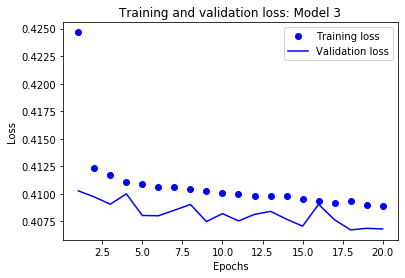

In [119]:
loss3 = plot_loss_metrics(history_dict3, 20, '3')
loss3.savefig('model3_loss.png')

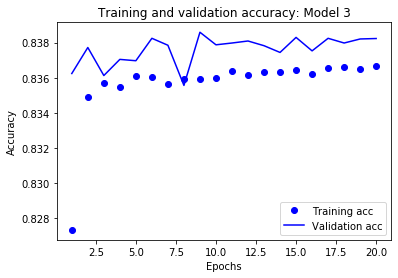

In [120]:
acc3 = plot_acc_metrics(history_dict3, 20, '3')
acc3.savefig('model3_acc.png')

In [49]:
pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])



,loss,categorical_accuracy,val_loss,val_categorical_accuracy
model1,43.904725,81.942129,43.727929,82.071871
model2,48.935676,80.610973,48.810034,80.694455
model3,40.886731,83.667743,40.680953,83.823323
